## Vision transformers

Outline:
- Fill in model architecture (maybe ask them to implement attention by hand? might be too hard)
- Load pretrained weights
- Load ImageNet
- Fine-tune on ImageNet (write training loop)

## Vision transformer architecture

First, go to **vit_architecture.py** and fill in some model definitions. You might find this illustration of the architecture of a vision transformer helpful (Figure 1 from the [ViT paper](https://arxiv.org/pdf/2010.11929.pdf)).

![](vit_architecture.png)

Once you complete all the TODOs, run the cell below to import the model.

In [1]:
%load_ext autoreload
%autoreload 2

from vit_architecture_solutions import VisionTransformer
# from vit_architecture import VisionTransformer

config = {
    "num_classes": 10,
    "patch_size": 16,
    "hidden_size": 768,
    "model_name": 'ViT-S_16',
}

transformer_config = {
    "mlp_dim": 3072,
    "num_heads": 12,
    "num_layers": 12,
    "attention_dropout_rate": 0.0,
    "dropout_rate": 0.0,
}

model = VisionTransformer(
    num_classes=config["num_classes"], 
    patch_size=config["patch_size"],
    hidden_size=config["hidden_size"],
    model_name=config["model_name"],
    transformer_config=transformer_config,
)

model

VisionTransformer(
    # attributes
    num_classes = 10
    patch_size = 16
    hidden_size = 768
    transformer_config = {'mlp_dim': 3072, 'num_heads': 12, 'num_layers': 12, 'attention_dropout_rate': 0.0, 'dropout_rate': 0.0}
    cls_head_bias_init = 0.0
    model_name = 'ViT-S_16'
)

## Load pre-trained weights

In [2]:
import os
import numpy as np
import jax
import jax.numpy as jnp
from vit_utils import load_pretrained
jax.local_devices() # shows available devices

2022-12-05 06:33:38.968376: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-05 06:33:38.968447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-05 06:33:38.968458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/ubuntu/anaconda3/envs/cs182/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook 

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [3]:
# Download pretrained S_16 checkpoint
checkpoint_file = "S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz"
if not os.path.exists("checkpoints"):
    os.system("mkdir checkpoints")
os.chdir("checkpoints")
if not os.path.exists(checkpoint_file):
    os.system(f"wget https://storage.googleapis.com/vit_models/augreg/{checkpoint_file}")
os.chdir("..")
with open(f"checkpoints/{checkpoint_file}", "rb") as f:
    ckpt_dict = np.load(f, allow_pickle=False)
    keys, values = zip(*list(ckpt_dict.items()))

# Initialize the model with random parameters
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    np.random.randn(2, 224, 224, 3),
    train=False,
), backend='cpu')()

In [4]:
# Load checkpoint
params = load_pretrained(
    pretrained_path=f'checkpoints/{checkpoint_file}',
    init_params=variables['params'],
)

load_pretrained: resized variant: %s to %s (1, 197, 384) (1, 197, 768)
load_pretrained: grid-size from %s to %s 14 14


## Load ImageNet

Files already downloaded and verified
Files already downloaded and verified


image.shape=torch.Size([3, 32, 32])
label=3


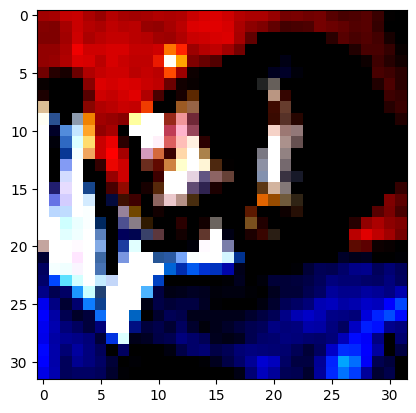

In [26]:
from torch.utils.data import DataLoader
from vit_utils import get_cifar10, NumpyLoader, one_hot, accuracy
import matplotlib.pyplot as plt
import einops

n_targets = 10
batch_size = 128
cifar10_train, cifar10_test = get_cifar10()
# cifar10_train = NumpyLoader(cifar10_train, batch_size=batch_size, num_workers=0)
# cifar10_test = NumpyLoader(cifar10_test, batch_size=batch_size, num_workers=0)
# batch = next(iter(cifar10_test))
for image, label in cifar10_test:
    print(f"{image.shape=}")
    plt.imshow(einops.rearrange(image, "c h w -> h w c"))
    print(f"{label=}")
    break

In [23]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(cifar10_train.train_data).reshape(len(cifar10_train.train_data), -1)
train_labels = one_hot(np.array(cifar10_train.train_labels), n_targets)

# Get full test dataset
test_images = jnp.array(cifar10_test.test_data.numpy().reshape(len(cifar10_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(cifar10_test.test_labels), n_targets)

AttributeError: 'CIFAR10' object has no attribute 'train_data'

In [28]:
out = model(image.numpy())

CallCompactUnboundModuleError: Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)

In [30]:
import flax

# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (10,)
params_repl.cls: ShardedDeviceArray (1, 10)


In [31]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [ ]:

def get_accuracy(params_repl, torch_loader: DataLoader):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
  for image, label in torch_loader:
    image = image.numpy()
    predicted = vit_apply_repl(params_repl, image)
    print(predicted.shape)
    print(label.shape)
    break
    is_same = predicted.argmax(axis=-1) == label.argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good #/ total



## Fine-tune